**COURSEWORK 1: NEURAL NETWORKS AND DEEP LEARNING**

We train the dataset to classify images into 10 classes

Importing the Libraries 

In [1]:
#importing pytorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F



**TASK 1: Read Dataset and Create Data Loaders**




Load and normalize the CIFAR10 training and test datasets using torchvision

In [2]:

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


**TASK 2: Create the Model**

Define a Convolutional Neural Network witht the following architecture

Number of blocks - 2

Number of Convolutions - 4

Input shape (3, 32, 32)

Input features - 3

Output Classes - 10

Activation Functions: ReLU, Tanh

In [3]:
#Define Convolution network
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #block 1
        #Spatial Average pooling
        self.spa_pool_1 = nn.AdaptiveAvgPool2d(output_size=(1, 1))

        #Flatten
        self.flat_1 = nn.Flatten()

        #Linear layer, with 3 input features and 4 convolutions
        self.linear_1 = nn.Linear(3, 4)
            
        #non-linear activation function, ReLU
        self.relu_1 =  nn.Tanh()

        # add convolutional layers, each wil be multiplied by an element of output from the MLP layer
        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)

        #block 2
        self.spa_pool_2 = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.flat_2 = nn.Flatten()
        self.linear_2 = nn.Linear(32, 4)
        self.relu_2 =  nn.ReLU()

        # add convolutional layers, each multiplied by an element of e
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3, stride=1, padding=1)

        self.tanh =  nn.Tanh()

        '''#block 3
        self.spa_pool_3 = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.flat_3 = nn.Flatten()
        self.linear_3 = nn.Linear(32, 4)
        self.relu_3 =  nn.Tanh()

        # add convolutional layers, each multiplied by an element of e
        self.conv_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        #block 4
        self.spa_pool_4 = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.flat_4 = nn.Flatten()
        self.linear_4 = nn.Linear(64, 4)
        self.relu_4 =  nn.Tanh()

        # add convolutional layers, each multiplied by an element of e
        self.conv_4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)'''

        # add the classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            nn.Flatten(),
            nn.Linear(in_features=128, out_features=10)
        )

    def forward(self, x):

       #block 1
       lin_1 = self.spa_pool_1(x) # reduce spatial dimensions to 1x1 while preserving channel dimension
       
       lin_1 = self.flat_1(lin_1) # flatten to (batch_size, input_channel)

       lin_1 = self.linear_1(lin_1) #linear layer

       lin_1 = self.relu_1(lin_1) #apply relu activation function

       # divide lin_1 into a1, a2, a3, a4 cuz we have 4 parallel convolutions
       a1 = (lin_1[:, 0].view((4, 1))).unsqueeze(-1).unsqueeze(-1) #unsqueeze add dimensions to match dimensions of conv layer to get product
       a2 = (lin_1[:, 1].view((4, 1))).unsqueeze(-1).unsqueeze(-1)
       a3 = (lin_1[:, 2].view((4, 1))).unsqueeze(-1).unsqueeze(-1)
       a4 = (lin_1[:, 3].view((4, 1))).unsqueeze(-1).unsqueeze(-1)

       conv_output_1 = self.conv_1(x) #convolution layer

       #output as product of convlution and mlp
       b1_out1 = a1 * conv_output_1
       b1_out2 = a2 * conv_output_1
       b1_out3 = a3 * conv_output_1
       b1_out4 = a4 * conv_output_1

       #sum of output from convolution and mlp to get output of block 1, O_1
       block_output_1 = b1_out1 + b1_out2 + b1_out3 + b1_out4

       #block 2
       # reduce spatial dimensions to 1x1 while preserving channel dimension 
       lin_2 = self.spa_pool_2(block_output_1)#input to pooling is output from previous block
       
       lin_2 = self.flat_2(lin_2)
      
       lin_2 = self.linear_2(lin_2) #linear layer
      
       lin_2 = self.relu_2(lin_2)
      
       a5 = (lin_2[:, 0].view((4, 1))).unsqueeze(-1).unsqueeze(-1)
       a6 = (lin_2[:, 1].view((4, 1))).unsqueeze(-1).unsqueeze(-1)
       a7 = (lin_2[:, 2].view((4, 1))).unsqueeze(-1).unsqueeze(-1)
       a8 = (lin_2[:, 3].view((4, 1))).unsqueeze(-1).unsqueeze(-1)
       
       #convolution layer
       conv_output_2 = self.conv_2(block_output_1) #input is output from previous block

       conv_output_2 = self.tanh(conv_output_2) #tanh activation to improve performance

       #comput product and sum to get output for the block
       b2_out1 = a5 * conv_output_2
       b2_out2 = a6 * conv_output_2
       b2_out3 = a7 * conv_output_2
       b2_out4 = a8 * conv_output_2
       block_output_2 = b2_out1 + b2_out2 + b2_out3 + b2_out4
         
       '''
       #block 3
       lin_3 = self.spa_pool_3(block_output_2) # reduce spatial dimensions to 1x1 while preserving channel dimension
       #print(block_output_1.size())
       #print(lin_2.size())
       lin_3 = self.flat_3(lin_3)
       #print(lin_2.size())
       #xp = xp.view(xp.size(0), -1) # flatten to (batch_size, input_channel)
       lin_3 = self.linear_3(lin_3) #linear layer
       #print(lin_2.size())
       lin_3 = self.relu_3(lin_3)
       #print(lin_2.size())
       # divide x into a1, a2, cuz we have 2 parallel conv
       a9 = (lin_3[:, 0].view((4, 1))).unsqueeze(-1).unsqueeze(-1)
       a10 = (lin_3[:, 1].view((4, 1))).unsqueeze(-1).unsqueeze(-1)
       a11 = (lin_3[:, 2].view((4, 1))).unsqueeze(-1).unsqueeze(-1)
       a12 = (lin_3[:, 3].view((4, 1))).unsqueeze(-1).unsqueeze(-1)
       #print("a3, a4", a3)
       
       conv_output_3 = self.conv_3(block_output_2) #convolution layer
       conv_output_3 = self.tanh(conv_output_3) 

       #output per block
       b3_out1 = a9 * conv_output_3
       b3_out2 = a10 * conv_output_3
       b3_out3 = a11 * conv_output_3
       b3_out4 = a12 * conv_output_3
       block_output_3 = b3_out1 + b3_out2 + b3_out3 + b3_out4

       #block 4
       lin_4 = self.spa_pool_4(block_output_3) # reduce spatial dimensions to 1x1 while preserving channel dimension
       #print(block_output_1.size())
       #print(lin_2.size())
       lin_4 = self.flat_4(lin_4)
       #print(lin_2.size())
       #xp = xp.view(xp.size(0), -1) # flatten to (batch_size, input_channel)
       lin_4 = self.linear_4(lin_4) #linear layer
       #print(lin_2.size())
       lin_4 = self.relu_4(lin_4)
       #print(lin_2.size())
       # divide x into a1, a2, cuz we have 2 parallel conv
       a13 = (lin_4[:, 0].view((4, 1))).unsqueeze(-1).unsqueeze(-1)
       a14 = (lin_4[:, 1].view((4, 1))).unsqueeze(-1).unsqueeze(-1)
       a15 = (lin_4[:, 2].view((4, 1))).unsqueeze(-1).unsqueeze(-1)
       a16 = (lin_4[:, 3].view((4, 1))).unsqueeze(-1).unsqueeze(-1)
       #print("a3, a4", a3)
       
       conv_output_4 = self.conv_4(block_output_3) #convolution layer

       #output per block
       b4_out1 = a13 * conv_output_4
       b4_out2 = a14 * conv_output_4
       b4_out3 = a15 * conv_output_4
       b4_out4 = a16 * conv_output_4
       block_output_4 = b4_out1 + b4_out2 + b4_out3 + b4_out4
       
       '''
        
       #softmax classifier
       out = self.classifier(block_output_2)

       return out
 

In [4]:
from torchvision import models
from torchsummary import summary

model = CNN()

print(model)

#summary(model, input_size=(3, 32, 32))

CNN(
  (spa_pool_1): AdaptiveAvgPool2d(output_size=(1, 1))
  (flat_1): Flatten(start_dim=1, end_dim=-1)
  (linear_1): Linear(in_features=3, out_features=4, bias=True)
  (relu_1): Tanh()
  (conv_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (spa_pool_2): AdaptiveAvgPool2d(output_size=(1, 1))
  (flat_2): Flatten(start_dim=1, end_dim=-1)
  (linear_2): Linear(in_features=32, out_features=4, bias=True)
  (relu_2): ReLU()
  (conv_2): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (tanh): Tanh()
  (classifier): Sequential(
    (0): AdaptiveAvgPool2d(output_size=(1, 1))
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [5]:
train_inputs, train_label = next(iter(trainloader))

test_inputs, test_label = next(iter(trainloader))

train_inputs.size()

torch.Size([4, 3, 32, 32])


The function: evaluation, takes as parameter the dataset and calculates the accuracy on the train and test sets





In [6]:
def evaluation(dataloader):
  total, correct = 0,0
  # evaluate mode de-activates certain modes such as dropout
  net.eval()
  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = net(inputs)
    # we take the index of the class that received the highest value  
    # we take outputs.data so that no backpropagation is performed for these outputs
    _, pred = torch.max(outputs.data, 1)
    total += labels.size(0)
    # .item() takes Python float values from the tensor
    correct += (pred == labels).sum().item()
  return 100 * correct / total

Initializing the weights

In [7]:
def weights_init(m):
    # initialise weights for both linear and convolutional layers
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight)

**Create Loss and Optimizer**

*   In this block of code, we define a loss function, we use Cross-Entropy loss.
*   We also define the optimzer, we use the SGD optimizer
*   Next We train the inetwork on the training data
*   And finally we test the model on the test data





In [8]:
#training on the GPU
device = torch.device("cuda:0")

#initialise learning rate to 0.1
alpha = 0.01

#initialize training instance
net = CNN().to(device)

# call function to initialise weights
net.apply(weights_init)

# use cross entrophy loss
loss_fn = nn.CrossEntropyLoss()
loss_fn.to(device)

# SGD optimiser, learning rate is specified by alpha
opt = torch.optim.SGD(list(net.parameters()), lr=alpha)
    
loss_epoch_array = []
max_epochs = 50
loss_epoch = 0
train_accuracy = []
test_accuracy = []
# loop over epochs
for epoch in range(max_epochs):
  # we will compute sum of batch losses per epoch
  loss_epoch = 0
  # loop over batches
  for i, data in enumerate(trainloader, 0):
    # to ensure the training mode is "turned on"
    net.train()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    # zero the gradients
    opt.zero_grad()
    outputs = net(inputs)
    # compute the loss
    loss = loss_fn(outputs, labels)
    # calculate the gradients
    loss.backward()
    # update the parameters using the gradients and optimizer algorithm 
    opt.step()
    # we sum the loss over batches
    loss_epoch += loss.item()

  
  loss_epoch_array.append(loss_epoch)
  train_accuracy.append(evaluation(trainloader))
  test_accuracy.append(evaluation(testloader))
  print("Epoch {}: loss: {}, train accuracy: {}, valid accuracy:{}".format(epoch + 1, loss_epoch_array[-1], train_accuracy[-1], test_accuracy[-1]))

Epoch 1: loss: 25885.88175547123, train accuracy: 24.17, valid accuracy:24.84
Epoch 2: loss: 24494.958487927914, train accuracy: 30.016, valid accuracy:30.15
Epoch 3: loss: 22509.51967817545, train accuracy: 38.344, valid accuracy:38.38
Epoch 4: loss: 20646.89519110322, train accuracy: 43.186, valid accuracy:42.26
Epoch 5: loss: 19330.577872902155, train accuracy: 44.294, valid accuracy:43.67
Epoch 6: loss: 18304.10218563676, train accuracy: 49.748, valid accuracy:48.81
Epoch 7: loss: 17585.305285081267, train accuracy: 46.912, valid accuracy:45.77
Epoch 8: loss: 17061.972237691283, train accuracy: 53.246, valid accuracy:52.48
Epoch 9: loss: 16631.65102753043, train accuracy: 54.652, valid accuracy:53.61
Epoch 10: loss: 16283.021145634353, train accuracy: 55.716, valid accuracy:54.38
Epoch 11: loss: 16012.239794135094, train accuracy: 54.28, valid accuracy:53.75
Epoch 12: loss: 15772.094803482294, train accuracy: 55.048, valid accuracy:54.05
Epoch 13: loss: 15540.796708516777, train ac

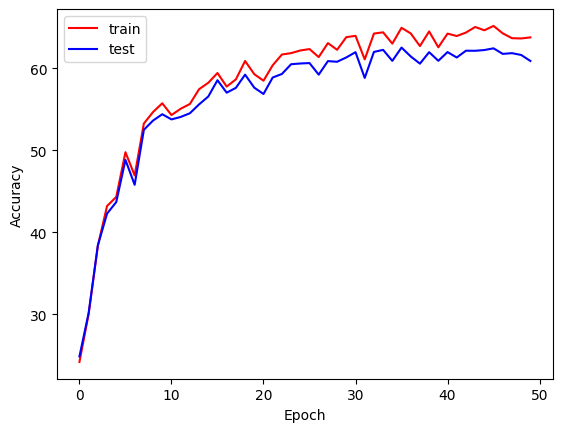

In [9]:
from matplotlib import pyplot as plt

#plot accuracy per epoch on training and test set
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_accuracy, "r")
plt.plot(test_accuracy, "b")
plt.gca().legend(('train','test'))

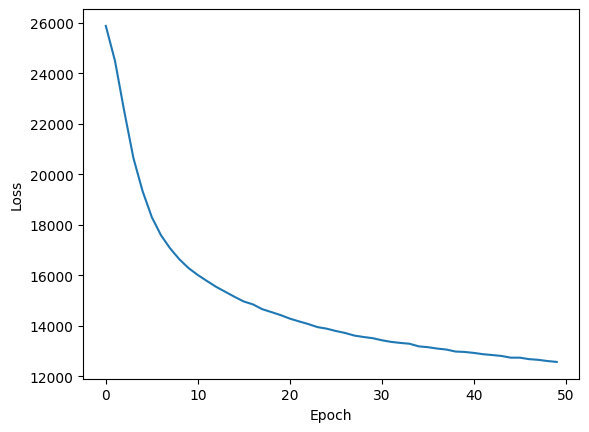

In [10]:
#plot loss of training set per epoch
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(loss_epoch_array)